# Ground-roll attenuation

## Content
* [Problem description](#Problem-description)
* [Dataset](#Dataset)
* [Model architecture](#Model-architecture)
* [Training](#Training)
* [Model evaluation](#Model-evaluation)
* [Inference](#Inference)

## Problem description

Raw field seismograms contain noises of various nature. One type of noise is assosiated with ground-roll waves propagation. It should be suppressed at initial stage of seismograms processing. In this notebook we will train a ground-roll attenuation model and process the seismograms.

## Dataset

Dataset is given by 2 SEGY files with a seismogram before and after ground-roll attenuation according to LIFT procedure. The seismorgam contains 176K traces combined in 51 field records. 

First, we index field records:

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

sys.path.append('..')

from geolog.batchflow import Dataset, DatasetIndex, Pipeline, B, V, F
from geolog.batchflow.models.tf import UNet

from geolog.src import (SeismicBatch, FieldIndex, TraceIndex,
                        seismic_plot, spectrum_plot, merge_segy_files,
                        show_statistics)

%env CUDA_VISIBLE_DEVICES=4

path_raw = '/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '../../noise_data/DN02B_SHOTS_LIFT1.sgy'

index = (FieldIndex(name='raw', extra_headers=['offset', 'INLINE_3D', 'CROSSLINE_3D'],
                    path=path_raw)
         .merge(FieldIndex(name='lift', path=path_lift)))

index.head()

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


env: CUDA_VISIBLE_DEVICES=4


,CROSSLINE_3D,offset,TraceNumber,INLINE_3D,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,,,raw,raw,lift,lift
FieldRecord,,,,,,,,
111906,550,35,1656,1617,1,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,1,../../noise_data/DN02B_SHOTS_LIFT1.sgy
111906,551,36,1657,1617,2,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,2,../../noise_data/DN02B_SHOTS_LIFT1.sgy
111906,549,78,1655,1617,3,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,3,../../noise_data/DN02B_SHOTS_LIFT1.sgy
111906,552,79,1658,1617,4,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,4,../../noise_data/DN02B_SHOTS_LIFT1.sgy
111906,548,127,1654,1617,5,/notebooks/egor/noise_data/DN02A_LIFT_AMPSCAL.sgy,5,../../noise_data/DN02B_SHOTS_LIFT1.sgy


Load and visualize sample field record:

In [2]:
batch = (Dataset(index, SeismicBatch).next_batch(3)
         .load(components=('raw', 'lift'), fmt='segy')
         .sort_traces(src=('raw', 'lift'), dst=('raw', 'lift'), sort_by='offset'))

Show raw and filtered traces (sorted by offset):

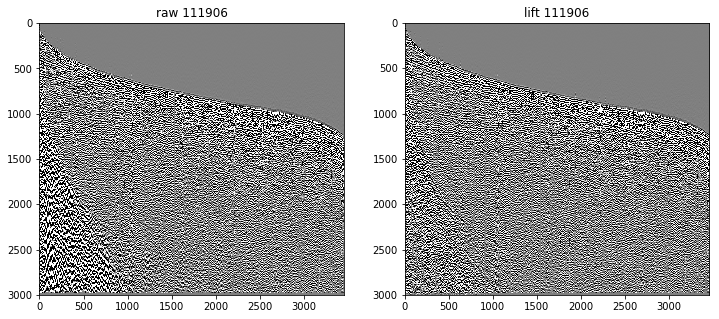

In [3]:
cv = 0.1
batch.seismic_plot(('raw', 'lift'), batch.indices[0], figsize=(12, 5), vmin=-cv, vmax=cv, cmap='gray')

## Model architecture

We exploit a convolutional neural network of the U-net type with depth 4.
Set the model config:

In [4]:
model_config = {
    'initial_block/inputs': 'x',
    'inputs': dict(x={'shape': (3000, 1)}, 
                   y={'name':'targets', 'shape': (3000, 1)}),
    'body/filters': [8, 16, 32, 64, 128],
    'body/encoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
    'body/downsample': dict(layout='pd', pool_size=2, pool_strides=2, dropout_rate=0.05),
    'body/decoder': dict(layout='caca', kernel_size=7, activation=tf.nn.elu),
    'body/upsample': dict(layout='tad', kernel_size=7, strides=2,
                          dropout_rate=0.05, activation=tf.nn.elu),
    'loss':'l1',
    'optimizer': 'Adam'
}

## Training

Define train dataset:

In [5]:
train_index = index.create_subset(index.indices[:5])
train_set = Dataset(TraceIndex(train_index), SeismicBatch)

Set a training pipeline

In [6]:
def make_data(batch, **kwagrs):
    return {"feed_dict": {'x': np.expand_dims(np.vstack(batch.raw), -1),
                          'y': np.expand_dims(np.vstack(batch.lift), -1)}}

train_pipeline = (Pipeline()
                  .load(components=('raw', 'lift'), fmt='segy', tslice=np.arange(3000))
                  .init_variable('loss', init_on_each_run=list)
                  .init_model('dynamic', UNet, 'unet', model_config)
                  .train_model('unet', make_data=make_data,
                               fetches='loss', save_to=V('loss'), mode='a')
                 )

Run the training pipeline

In [7]:
batch_size = 64

train_pipeline = train_pipeline << train_set
train_pipeline.run(batch_size, n_epochs=3, drop_last=True, shuffle=True, bar=True)

  0%|          | 0/810 [00:00<?, ?it/s]

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


100%|█████████▉| 809/810 [01:50<00:00,  7.65it/s]


Loss against iterations:

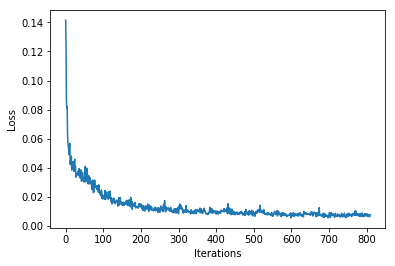

In [8]:
plt.plot(train_pipeline.get_variable("loss"))
plt.xlabel("Iterations"), plt.ylabel("Loss")
plt.show()

Dump the model:

In [9]:
# train_pipeline.save_model('unet', './unet_model')

## Model evaluation

Inference pipeline for a quick model estimation:

In [10]:
model_config = {
    "build": False,
    "load": {"path": './unet_model'},
}

def make_data(batch, **kwagrs):
    return {"feed_dict": {'x': np.expand_dims(np.vstack(batch.raw), -1)}}

predict_pipeline = (Pipeline()
                    .import_model('unet', train_pipeline)
#                     .init_model("static", UNet, 'unet', config=model_config)
                    .init_variable('res', init_on_each_run=list())
                    .init_variable('raw', init_on_each_run=list())
                    .init_variable('lift', init_on_each_run=list())
                    .load(components=('raw', 'lift'), tslice=np.arange(3000),
                          fmt='segy')
                    .update_variable('raw', B('raw'), mode='a')
                    .update_variable('lift', B('lift'), mode='a')
                    .predict_model('unet', fetches='predictions', make_data=make_data,
                                   save_to=V('res'), mode='a')
                   )

Define a test field record:

In [11]:
test_set = Dataset(TraceIndex(index.create_subset(index.indices[20:21])), SeismicBatch)

Run the inference pipeline on the test subset:

In [12]:
predict_pipeline = predict_pipeline << test_set
predict_pipeline.run(batch_size=1000, n_epochs=1, drop_last=False, shuffle=False, bar=True)

 75%|███████▌  | 3/4 [00:01<00:00,  2.14it/s]


Arrange results:

In [13]:
res = np.squeeze(np.vstack(predict_pipeline.get_variable("res")), axis=-1)
raw = np.vstack(np.concatenate(predict_pipeline.get_variable("raw")))
lift = np.vstack(np.concatenate(predict_pipeline.get_variable("lift")))

Show raw traces, Unet prediction and difference between them:

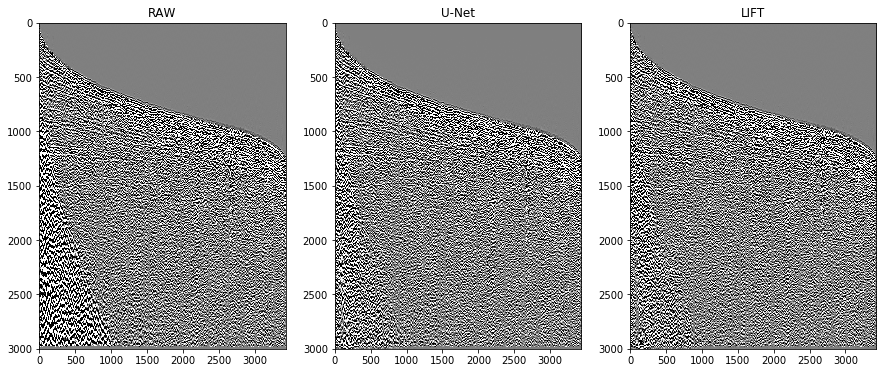

In [14]:
seismic_plot([raw, res, lift], names=['RAW', 'U-Net', 'LIFT'],
             figsize=(15, 6), vmin=-cv, vmax=cv, cmap='gray')

Power spectrum comparison:

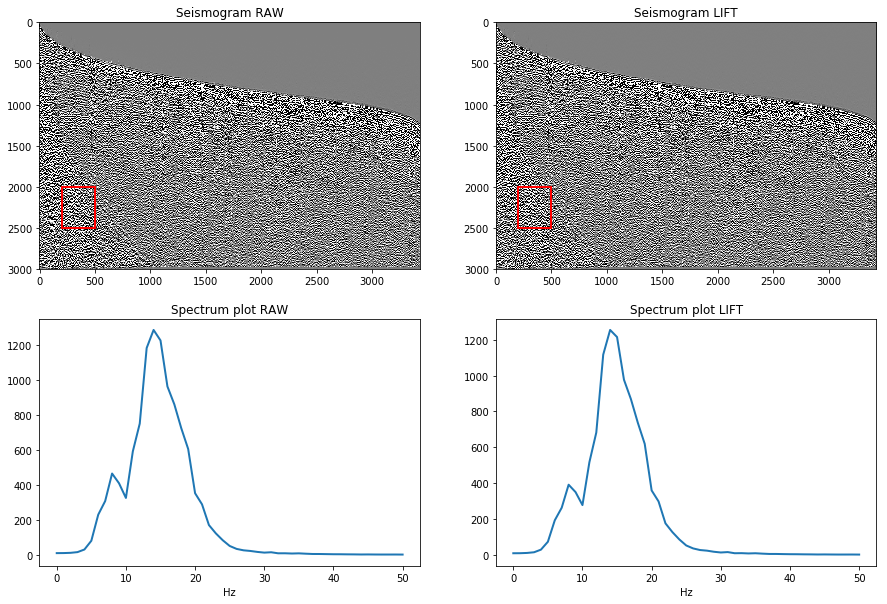

In [15]:
spectrum_plot([res, lift], frame=(slice(200, 500), slice(2000, 2500)), rate=0.002, max_freq=50,
              figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray', names=['RAW', 'LIFT'])

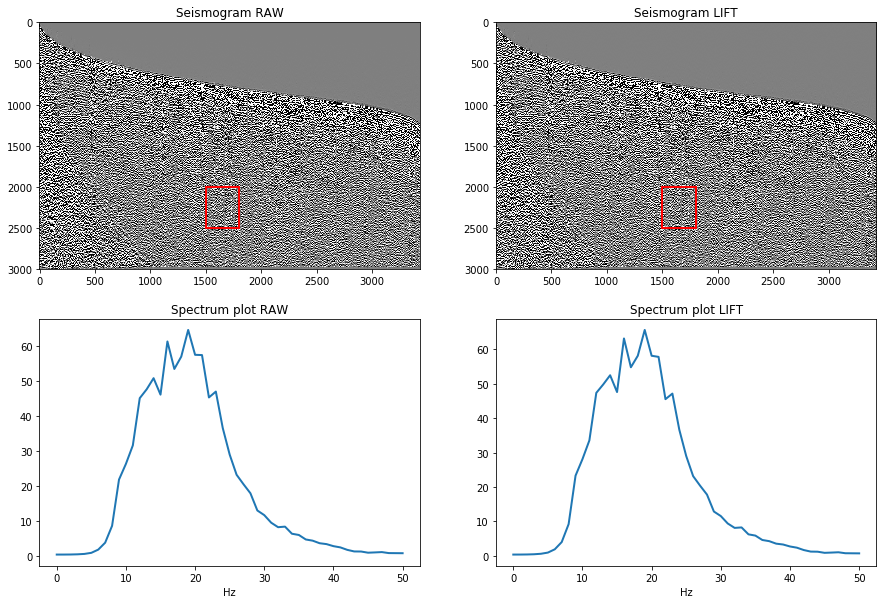

In [16]:
spectrum_plot([res, lift], frame=(slice(1500, 1800), slice(2000, 2500)), rate=0.002, max_freq=50,
              figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray', names=['RAW', 'LIFT'])

Processed signal statistics in time domain:

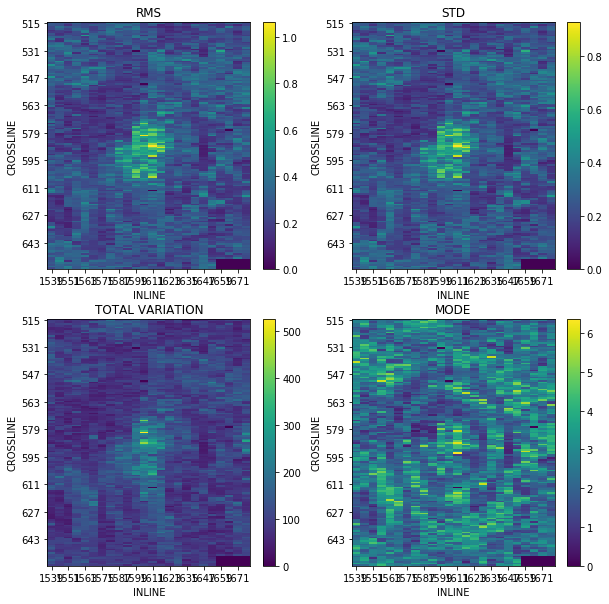

In [17]:
iline = test_set.index.get_df()['INLINE_3D']
xline = test_set.index.get_df()['CROSSLINE_3D']
show_statistics(res, domain='time', iline=iline, xline=xline, figsize=(10, 10))

Processed signal statistics in frequency domain:

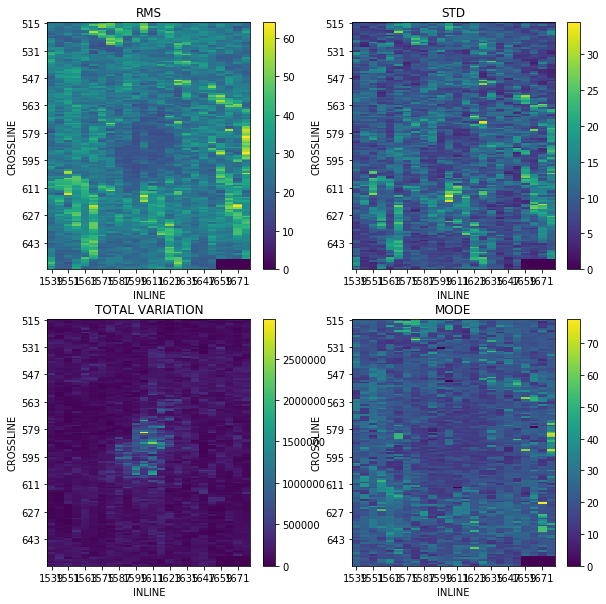

In [19]:
iline = test_set.index.get_df()['INLINE_3D']
xline = test_set.index.get_df()['CROSSLINE_3D']
show_statistics(res, domain='frequency', rate=0.002,
                iline=iline, xline=xline, figsize=(10, 10))

Processed and target signal difference statistics in time domain:

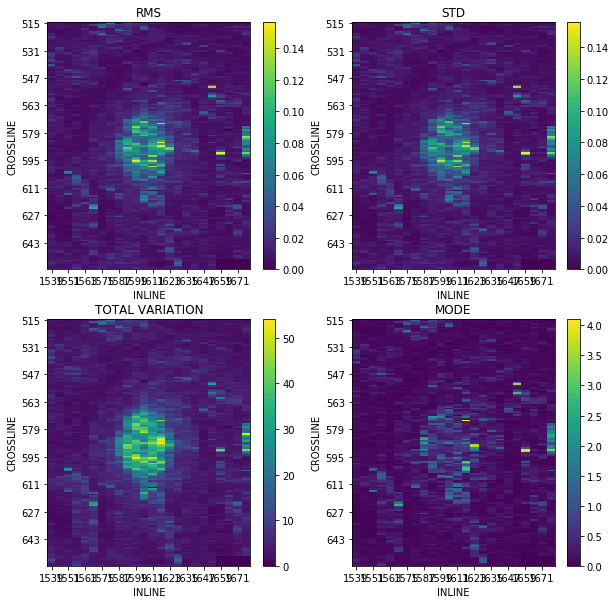

In [20]:
iline = test_set.index.get_df()['INLINE_3D']
xline = test_set.index.get_df()['CROSSLINE_3D']
show_statistics(res - lift, domain='time',
                iline=iline, xline=xline, figsize=(10, 10))

Processed and target signal difference statistics in frequency domain:

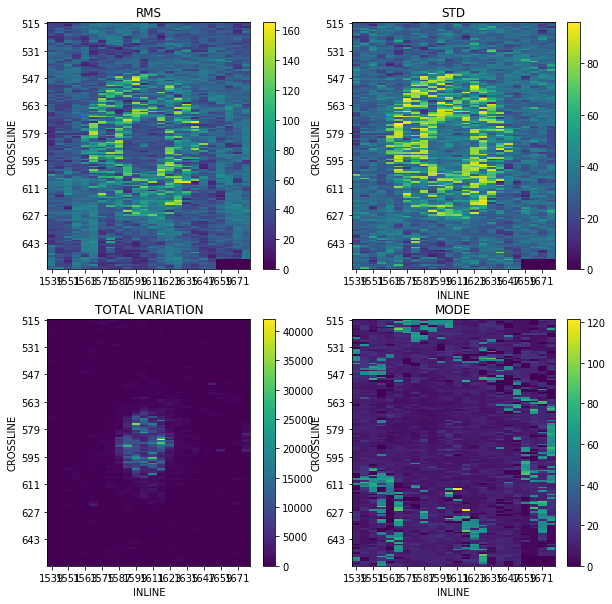

In [21]:
iline = test_set.index.get_df()['INLINE_3D']
xline = test_set.index.get_df()['CROSSLINE_3D']
show_statistics(res - lift, domain='frequency', rate=0.002,
                iline=iline, xline=xline, figsize=(10, 10))

## Inference

An inference pipeline with dump action:

In [18]:
model_config = {
    "build": False,
    "load": {"path": './unet_model'},
}

def make_data(batch, **kwagrs):
    return {"feed_dict": {'x': np.expand_dims(np.vstack(batch.raw), -1)}}

def unstack_results(batch, arr):
    indices = np.cumsum([len(x) for x in batch.raw[:-1]])
    return np.array(np.split(arr, indices) + [None])[:-1]

dump_path = '/notebooks/egor/geolog/notebooks/dumps'

predict_pipeline = (Pipeline()
                    .load(components='raw', fmt='segy', tslice=np.arange(3000))
                    .import_model('unet', train_pipeline)
#                     .init_model("static", UNet, 'unet', config=model_config)
                    .init_variable('res')
                    .init_variable('count', init_on_each_run=0)
                    .predict_model('unet', fetches='predictions', 
                                   make_data=make_data, save_to=V('res'))
                    .call(unstack_results, arr=V('res'), save_to=B('raw'))
                    .dump(fmt='segy', path=F(lambda _, x: os.path.join(dump_path, str(x) + '.sgy'), V('count')),
                          src='raw', split=False)
                    .update_variable('count', F(lambda _, x: x + 1, V('count')))
                   )

Run inference on the whole dataset:

In [19]:
batch_size = 1000
predict_pipeline = predict_pipeline << Dataset(TraceIndex(index), SeismicBatch)
predict_pipeline.run(batch_size, n_epochs=1, drop_last=False, shuffle=False, bar=True)

 99%|█████████▉| 175/176 [01:59<00:00,  1.47it/s]


Finally, merge the output files into a single segy file:

In [21]:
merge_segy_files(path=os.path.join(dump_path, '*sgy'),
                 output_path='/notebooks/egor/geolog/notebooks/merged.sgy')

Done!